In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [16]:
df = pd.read_csv("parkinson_disease.csv")
df.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


In [17]:
df01 = df.groupby('id').mean().reset_index()
df01.drop('id', axis=1, inplace=True)

In [18]:
df01.head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,1.0,0.823387,0.696370,0.567250,235.333333,234.333333,0.008220,0.000073,0.001963,0.000016,...,1.561733,2.862000,12.293333,9.717500,9.055300,6.259100,4.021533,4.164333,22.961700,1.0
1,0.0,0.415637,0.793993,0.592453,213.333333,211.000000,0.008884,0.001849,0.005790,0.000050,...,4.918567,4.827133,6.117633,8.599667,5.737233,7.933133,5.490533,4.941833,4.467233,1.0
2,1.0,0.801973,0.619967,0.520563,319.333333,318.333333,0.006041,0.000104,0.002217,0.000013,...,41.129400,31.201933,14.584467,5.446800,3.462000,4.772067,9.176633,11.848100,5.552367,1.0
3,0.0,0.828707,0.626097,0.537183,493.000000,492.000000,0.003913,0.000042,0.000757,0.000003,...,1.677633,1.908400,2.842167,3.493867,3.282433,3.085267,3.184433,4.032933,22.773633,1.0
4,0.0,0.831287,0.779397,0.726717,362.666667,361.666667,0.005622,0.002023,0.003593,0.000021,...,4.104600,4.285233,2.953200,2.799933,2.645100,2.811367,7.268333,13.338833,63.766900,1.0


In [19]:
corr_matrix = df01.drop(columns=['class']).corr().abs()

In [20]:
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

In [21]:
# Find columns with correlation greater than 0.7
to_drop = [
    column for column in upper.columns if any(upper[column] > 0.7)
]

In [25]:
# Drop them, but keep 'class'
df01_reduced = df01.drop(columns=to_drop)

In [28]:
# df01_reduced.head()
df = df01_reduced

In [29]:
X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape

(252, 31)

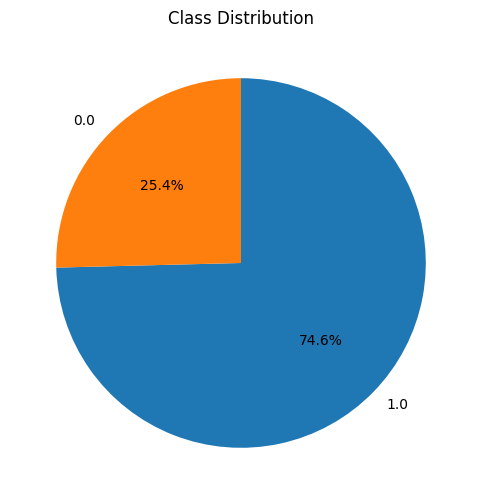

In [32]:
class_count = df['class'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    class_count,
    labels=class_count.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
plt.title("Class Distribution")
plt.show()

In [36]:
features = df.drop('class', axis=1)
target = df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                                  test_size=0.2,
                                                  random_state=10)

ros = RandomOverSampler(sampling_strategy=1.0,
                        random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)
print (X.shape, Y_train.value_counts(), Y.value_counts())

(302, 30) class
1.0    151
0.0     50
Name: count, dtype: int64 class
1.0    151
0.0    151
Name: count, dtype: int64


In [40]:
from sklearn.metrics import roc_auc_score as ras

models = [LogisticRegression(class_weight='balanced'), XGBClassifier(),
          SVC(kernel='rbf', probability=True)]

for model in models:

    model.fit(X, Y)
    print (f"{model} : \n")

    train_preds = model.predict(X)
    print ("Training Accuracy : ", ras(Y ,train_preds))

    val_preds = model.predict(X_val)
    print ("Validation Accuracy : ", ras(Y_val ,val_preds))
    print ('\n\n')


LogisticRegression(class_weight='balanced') : 

Training Accuracy :  0.7218543046357616
Validation Accuracy :  0.6148648648648649



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) : 

Training Accuracy :  1.0
Validation Accuracy :  0.6959459459459459



SVC(probability=True) : 

Traini

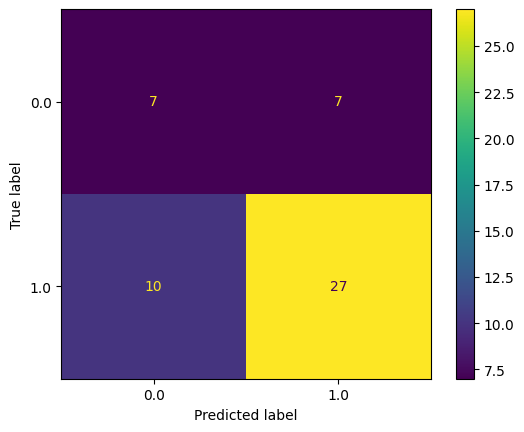

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X_val, Y_val)
plt.show()

In [45]:
from sklearn.metrics import classification_report

print (classification_report(Y_val, models[0].predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.41      0.50      0.45        14
         1.0       0.79      0.73      0.76        37

    accuracy                           0.67        51
   macro avg       0.60      0.61      0.61        51
weighted avg       0.69      0.67      0.68        51

